# 1-dimensional Regression Problem

In [21]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch.nn import functional as F
from sklearn.linear_model import LinearRegression

sys.path.append('..')

import seaborn as sns

import swag.utils as utils
from swag.posteriors import SWAG
from swag import models, losses, utils
from swag.models import MLP
#from subspace_sampling_utils import get_numpy, set_numpy, add_np_weights, norm, dist
from tqdm import tqdm

import os
os.sys.path.append("/home/izmailovpavel/Documents/Projects/curves/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
torch.backends.cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

## Data from the model

In [25]:
model_name = "ToyRegNet"
model_cfg = getattr(models, model_name)
criterion = losses.GaussianLikelihood(noise_var=1.)
model = model_cfg.base(*model_cfg.args, **model_cfg.kwargs)
model.load_state_dict(torch.load("data_generator4.pt"))

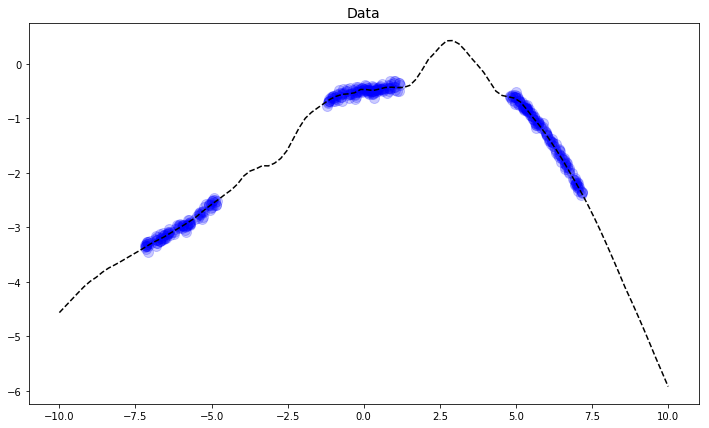

In [27]:
data = np.load("dataset_new.npz")
x = data["x"]
f = data["f"]
y = data["y"]
dataset = torch.utils.data.TensorDataset(torch.from_numpy(f.astype(np.float32)), torch.from_numpy(y.astype(np.float32)))
loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

def features(x):
    return np.hstack([x[:, None] / 2.0, (x[:, None] / 2.0) ** 2])


plt.figure(figsize=(12, 7))
plt.plot(x, y, 'bo', markersize=10, alpha=0.2)

z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k--')
plt.title("Data", fontsize=14)
plt.show()


In [28]:
from swag.posteriors.proj_model import SubspaceModel
import curves 

def get_pca_space():
    swag_model = SWAG(model_cfg.base, subspace_type="pca", *model_cfg.args, **model_cfg.kwargs, 
                  subspace_kwargs={"max_rank": 10, "pca_rank": 10})
    swag_model.load_state_dict(torch.load("swag-reg_final-3000.pt")["state_dict"])
    mean, _, cov_factor = swag_model.get_space()
    subspace = SubspaceModel(mean, cov_factor)
    return subspace

def get_rand_space(seed=1):
    swag_model = SWAG(model_cfg.base, subspace_type="pca", *model_cfg.args, **model_cfg.kwargs, 
                  subspace_kwargs={"max_rank": 10, "pca_rank": 10})
    swag_model.load_state_dict(torch.load("swag-reg_final-3000.pt")["state_dict"])
    mean, _, cov_factor = swag_model.get_space()
    torch.manual_seed(seed)
    cov_factor = torch.randn_like(cov_factor)
    cov_factor /= torch.norm(cov_factor, dim=1)[:, None]
    cov_factor *= 1e-2
    subspace = SubspaceModel(mean, cov_factor)
    return subspace
    
    
def get_curve_space():
    
    architecture = model_cfg.curve
    curve = curves.Bezier
    model_curve = curves.CurveNet(curve, architecture, 3, fix_end=True, fix_start=True, architecture_kwargs=model_cfg.kwargs)

    model_curve.load_state_dict(torch.load("reg_model_final_curve_01.pt"))
    W = []
    for i in range(3):
        model_curve.export_base_parameters(model, i)
        W.append(np.concatenate([param.data.numpy().reshape(-1) for param in model.parameters()]))
    W = np.vstack(W)

    mean = (W[0, :] + W[2, :]) / 2
    D = W[:2] - mean[None, :]
    D = D[:2]
    mean = torch.from_numpy(mean)
    D = torch.from_numpy(D).float()

    subspace = SubspaceModel(mean, D)
    return subspace, W, mean, D
    

In [29]:
def get_basis(W):
    basis1 = W[2, :] - W[0, :]
    basis2 = W[1, :] - W[0, :]
    basis1 /= np.linalg.norm(basis1)
    basis2 -= (basis2 @ basis1) * basis1
    # print(basis1 @ basis2)
    basis2 /= np.linalg.norm(basis2)
    origin = W[0, :]
    basis = np.vstack([basis1, basis2])
    return basis, origin

def curve_W(curve):
    W = []
    for i in range(3):
        model_curve.export_base_parameters(model, i)
        W.append(np.concatenate([param.data.numpy().reshape(-1) for param in model.parameters()]))
    W = np.vstack(W)
    return W
    
def visualize_samples(W, D, mean, samples, with_curve=True):
    
    basis, origin = get_basis(W)
    x2 = basis @ (W[2, :] - origin)
    x1 = basis @ (W[1, :] - origin)

    samples_new = (basis @ (mean.numpy() - origin))[None, :] + samples @ (D.numpy() @ basis.T)
    
    plt.figure(figsize=(10, 10))

    plt.plot(0, 0, "bo", ms=10)
    plt.plot(x1[0], x1[1], "bo", ms=10)
    plt.plot(x2[0], x2[1], "bo", ms=10)

    if with_curve:
        x0 = np.array([0, 0])
        ts = np.linspace(0, 1, 100)[:, None]
        xs = (1 - ts)**2 * x0[None, :] + 2 * (1 - ts) * ts * x1[None, :] + ts**2 * x2[None, :]
        plt.plot(xs[:, 0], xs[:, 1], "-g")
    plt.plot(samples_new[:, 0], samples_new[:, 1], "rx", ms=5, alpha=0.5, label="samples")
    plt.legend()
#     plt.title("Real NVP samples")
    

## Variational Inference

### PCA subspace

In [51]:
from swag.posteriors.vi_model import VIModel, ELBO
from swag.posteriors.proj_model import SubspaceModel
import math


In [53]:
subspace = get_pca_space()

In [54]:
init_sigma = 1.
prior_sigma = 50.
criterion = losses.GaussianLikelihood(noise_var=.5)

In [55]:
vi_model = VIModel(
    subspace=subspace,
    init_inv_softplus_sigma=math.log(math.exp(init_sigma) - 1.0),
    prior_log_sigma=math.log(prior_sigma),
    base=model_cfg.base,
    *model_cfg.args,
    **model_cfg.kwargs
)

elbo = ELBO(criterion, len(loader.dataset), temperature=1.)
optimizer = torch.optim.Adam([param for param in vi_model.parameters()], lr=.1)

In [56]:
for epoch in range(2000):
    train_res = utils.train_epoch(loader, vi_model, elbo, optimizer, regression=True, cuda=False)
    sigma = torch.nn.functional.softplus(vi_model.inv_softplus_sigma.detach().cpu())
    if epoch % 100 == 0:
        print(epoch, train_res)
#         print(sigma)
    if epoch == 1000:
        utils.adjust_learning_rate(optimizer, 0.01)

0 {'loss': 0.09551964793354273, 'accuracy': None, 'stats': {'nll': 0.0028669516614172608, 'kl': 0.09265269711613655}}
100 {'loss': 0.025595369981601834, 'accuracy': None, 'stats': {'nll': 0.004692065005656332, 'kl': 0.020903305150568485}}
200 {'loss': 0.02214107196778059, 'accuracy': None, 'stats': {'nll': 0.004646775079891086, 'kl': 0.01749429665505886}}
300 {'loss': 0.02340483944863081, 'accuracy': None, 'stats': {'nll': 0.006230028404388577, 'kl': 0.01717481086961925}}
400 {'loss': 0.020965357776731253, 'accuracy': None, 'stats': {'nll': 0.004005316004622728, 'kl': 0.016960041830316186}}
500 {'loss': 0.022798660676926374, 'accuracy': None, 'stats': {'nll': 0.00598758805426769, 'kl': 0.016811072826385498}}
600 {'loss': 0.022552198264747858, 'accuracy': None, 'stats': {'nll': 0.005754202313255519, 'kl': 0.01679799589328468}}
700 {'loss': 0.021697108866646886, 'accuracy': None, 'stats': {'nll': 0.004853924736380577, 'kl': 0.01684318413026631}}
800 {'loss': 0.021162016317248344, 'accura

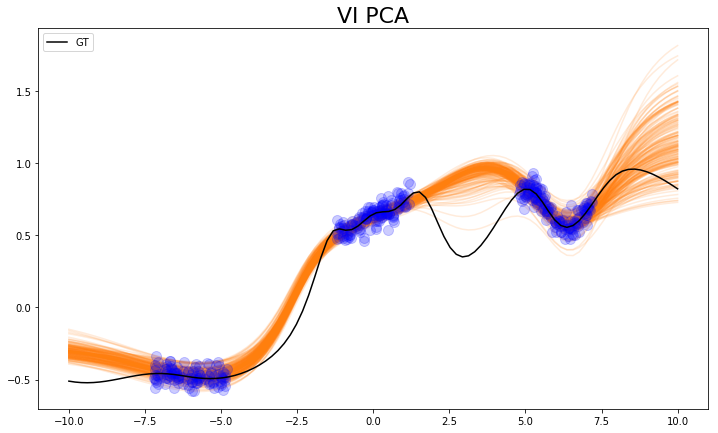

In [57]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))

trajectories = []
for i in range(200):
    out = vi_model(inp)
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    trajectories.append(out.detach().numpy().ravel())
    

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('VI PCA', fontsize=22)
plt.legend()
plt.show()


# np.savez("../../uai2k19_text/figs/data/toyreg/pca_vi_traj.npz", 
#             trajectories=trajectories,
#              x=z
#         )

In [58]:
# samples = torch.cat([vi_model.sample_z()[None,:] for _ in range(500)]).data.numpy()
# np.savez("../../uai2k19_text/figs/data/toyreg/pca_vi_samples.npz",
#          samples=samples,
#          cov_factor=subspace.cov_factor.numpy(),
#          mean=subspace.mean.numpy()
#         )

### VI, Random Subspace

In [98]:
from swag.posteriors.vi_model import VIModel, ELBO
from swag.posteriors.proj_model import SubspaceModel
import math


In [99]:
subspace = get_rand_space()
init_sigma = 1.
prior_sigma = 50.
criterion = losses.GaussianLikelihood(noise_var=.5)

vi_model = VIModel(
    subspace=subspace,
    init_inv_softplus_sigma=math.log(math.exp(init_sigma) - 1.0),
    prior_log_sigma=math.log(prior_sigma),
    base=model_cfg.base,
    *model_cfg.args,
    **model_cfg.kwargs
)

elbo = ELBO(criterion, len(loader.dataset), temperature=1.)
optimizer = torch.optim.Adam([param for param in vi_model.parameters()], lr=.1)

In [100]:
for epoch in range(2000):
    train_res = utils.train_epoch(loader, vi_model, elbo, optimizer, regression=True, cuda=False)
    sigma = torch.nn.functional.softplus(vi_model.inv_softplus_sigma.detach().cpu())
    if epoch % 100 == 0:
        print(epoch, train_res)
        print(sigma)
    if epoch == 1000:
        utils.adjust_learning_rate(optimizer, 0.01)

0 {'loss': 0.09549989737570286, 'accuracy': None, 'stats': {'nll': 0.0028469673707149923, 'kl': 0.0926529299467802}}
tensor([1.5694, 1.5693, 1.5693, 1.5694, 1.5693, 1.5693, 1.5693, 1.5691, 1.5694,
        1.5693])
100 {'loss': 0.023363071959465742, 'accuracy': None, 'stats': {'nll': 0.004939103790093213, 'kl': 0.018423967994749546}}
tensor([29.2051, 28.0910, 28.4656, 26.4647, 27.2055, 28.8025, 28.7262, 26.6831,
        29.2629, 28.1332])
200 {'loss': 0.019175376975908875, 'accuracy': None, 'stats': {'nll': 0.004513173596933484, 'kl': 0.01466220326256007}}
tensor([40.2479, 36.9510, 38.1531, 30.3474, 33.5540, 38.9667, 39.1255, 31.2448,
        41.3348, 37.9071])
300 {'loss': 0.02075084298849106, 'accuracy': None, 'stats': {'nll': 0.006755255744792521, 'kl': 0.013995587010867894}}
tensor([43.4990, 40.0326, 39.3963, 31.5982, 34.8405, 41.2028, 42.1707, 34.2250,
        46.2865, 40.1625])
400 {'loss': 0.023926461348310113, 'accuracy': None, 'stats': {'nll': 0.009996403357945383, 'kl': 0.0139

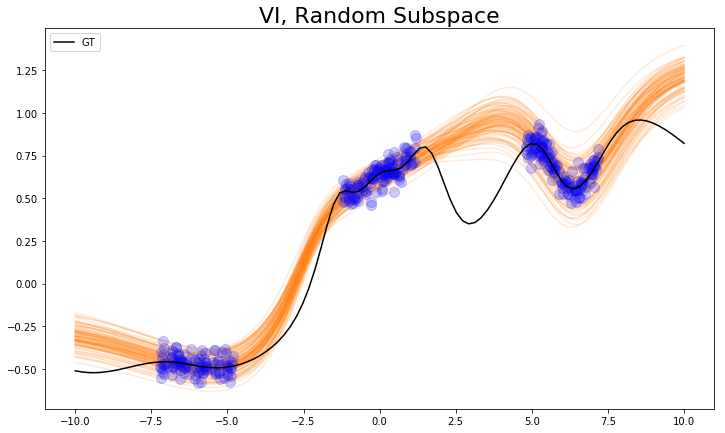

In [101]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))

trajectories = []
for i in range(100):
    out = vi_model(inp)
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    trajectories.append(out.detach().numpy().ravel())

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('VI, Random Subspace', fontsize=22)
plt.legend()
plt.show()

# np.savez("../../uai2k19_text/figs/data/toyreg/rand_vi_traj.npz", 
#             trajectories=trajectories,
#              x=z
#         )

In [102]:
# samples = torch.cat([vi_model.sample_z()[None,:] for _ in range(500)]).data.numpy()
# np.savez("../../uai2k19_text/figs/data/toyreg/rand_vi_samples.npz",
#          samples=samples,
#          cov_factor=subspace.cov_factor.numpy(),
#          mean=subspace.mean.numpy()
#         )

### VI-Curve

In [195]:
from swag.posteriors.vi_model import VIModel, ELBO
from swag.posteriors.proj_model import SubspaceModel
import math

In [196]:
subspace, W, mean, D = get_curve_space()
init_sigma = 1.
prior_sigma = 50.
criterion = losses.GaussianLikelihood(noise_var=.5)

vi_model = VIModel(
    subspace=subspace,
    init_inv_softplus_sigma=math.log(math.exp(init_sigma) - 1.0),
    prior_log_sigma=math.log(prior_sigma),
    base=model_cfg.base,
    *model_cfg.args,
    **model_cfg.kwargs
)

elbo = ELBO(criterion, len(loader.dataset), temperature=1.)
optimizer = torch.optim.Adam([param for param in vi_model.parameters()], lr=.1)

In [197]:
for epoch in range(2000):
    train_res = utils.train_epoch(loader, vi_model, elbo, optimizer, regression=True, cuda=False)
    sigma = torch.nn.functional.softplus(vi_model.inv_softplus_sigma.detach().cpu())
    if epoch % 100 == 0:
        print(epoch, train_res)
        print(sigma)
    if epoch == 1000:
        utils.adjust_learning_rate(optimizer, 0.01)

0 {'accuracy': None, 'stats': {'nll': 0.6125638200901449, 'kl': 0.020107426214963198}, 'loss': 0.6326712453737855}
tensor([0.7289, 0.7992])
100 {'accuracy': None, 'stats': {'nll': 0.007558326033176854, 'kl': 0.0339446822181344}, 'loss': 0.04150300845503807}
tensor([0.0476, 0.0667])
200 {'accuracy': None, 'stats': {'nll': 0.01910336161381565, 'kl': 0.03491219272837043}, 'loss': 0.05401555309072137}
tensor([0.0433, 0.0490])
300 {'accuracy': None, 'stats': {'nll': 0.0064356835500802845, 'kl': 0.03548157447949052}, 'loss': 0.0419172584079206}
tensor([0.0430, 0.0402])
400 {'accuracy': None, 'stats': {'nll': 0.010912071826169267, 'kl': 0.034808245953172445}, 'loss': 0.04572031833231449}
tensor([0.0513, 0.0423])
500 {'accuracy': None, 'stats': {'nll': 0.009637632523663342, 'kl': 0.03585518570616841}, 'loss': 0.04549281811341643}
tensor([0.0381, 0.0390])
600 {'accuracy': None, 'stats': {'nll': 0.006643757486017421, 'kl': 0.03531531756743789}, 'loss': 0.04195907432585955}
tensor([0.0388, 0.0479

In [206]:
# vi_model.load_state_dict(torch.load("toyreg_vi_curve.pt"))

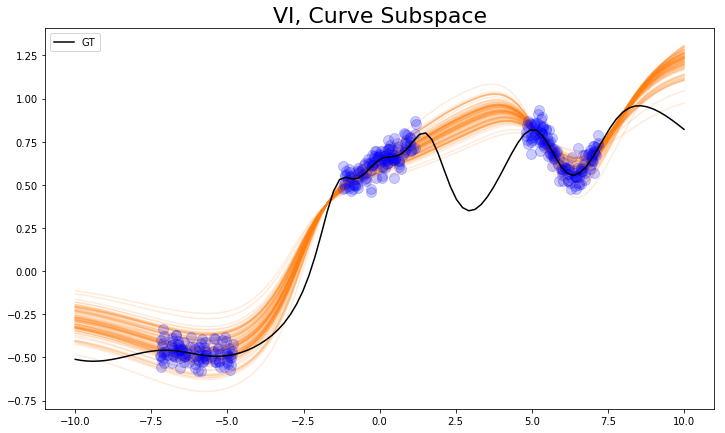

In [207]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))

trajectories = []
for i in range(100):
    out = vi_model(inp)
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    trajectories.append(out.detach().numpy().ravel())

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('VI, Curve Subspace', fontsize=22)
plt.legend()
plt.show()

# np.savez("../../uai2k19_text/figs/data/toyreg/curve_vi_traj.npz", 
#             trajectories=trajectories,
#              x=z
#         )

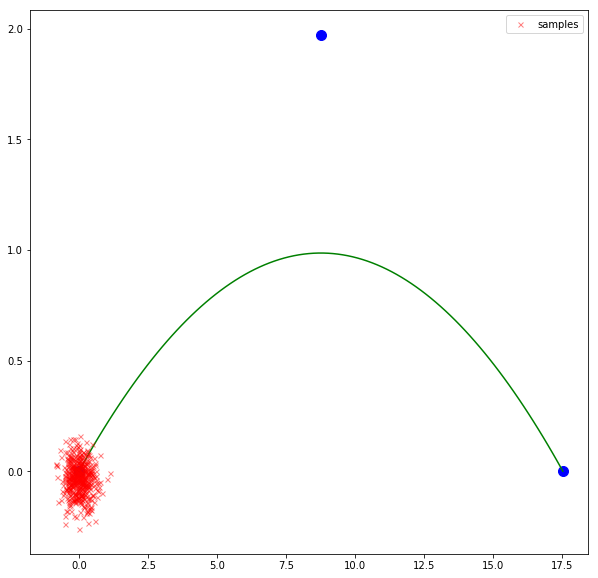

In [208]:
samples = torch.cat([vi_model.sample_z()[None,:] for _ in range(500)]).data.numpy()
visualize_samples(W, D, mean, samples, with_curve=True)

In [ ]:
# def curve_get_xy(point):
    
#     origin, vector_x, vector_y
#     return np.array([np.dot(point - origin, vector_x), np.dot(point - origin, vector_y)])

In [205]:
# np.savez("../../uai2k19_text/figs/data/toyreg/curve_vi_samples.npz",
#          samples=samples,
#          cov_factor=D,
#          mean=mean
#         )

# torch.save(vi_model.state_dict(), "toyreg_vi_curve.pt")

## Pyro Sampling

In [59]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import HMC, MCMC, NUTS

from swag.posteriors.pyro import PyroModel
from swag.utils import extract_parameters, set_weights

In [60]:
subspace = get_pca_space()

In [61]:
init_sigma = 1.
prior_sigma = 50.
criterion = losses.GaussianLikelihood(noise_var=.5)

In [62]:
prior_sigma = 50.
# criterion = losses.GaussianLikelihood(noise_var=.5)

pyro_model = PyroModel(
    base=model_cfg.base,
    subspace=subspace,
    prior_log_sigma=math.log(prior_sigma), 
    likelihood_given_outputs=lambda x: dist.Normal(x, np.sqrt(0.5)),
    *model_cfg.args,
    **model_cfg.kwargs
)


In [63]:
nuts_kernel = NUTS(pyro_model.model, step_size=1.)

In [64]:
x_, y_ = loader.dataset.tensors
mcmc_run = MCMC(nuts_kernel, num_samples=200, warmup_steps=100).run(x_, y_)
samples = torch.cat(list(mcmc_run.marginal(sites="t").support(flatten=True).values()), dim=-1)
# samples

Sample: 100%|██████████| 300/300 [00:48<00:00,  6.22it/s, step size=5.83e-01, acc. rate=0.957]


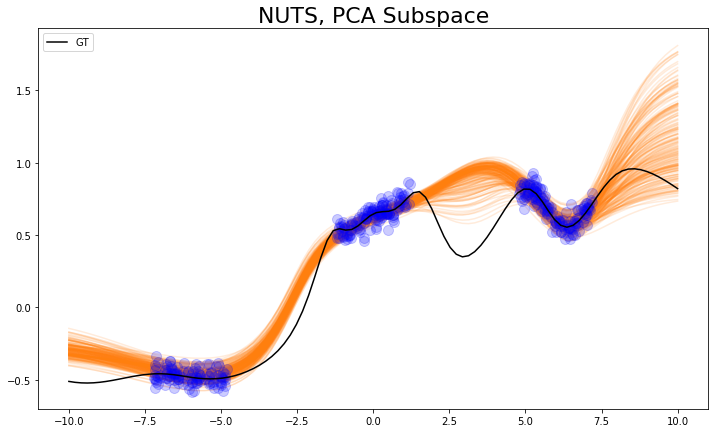

In [65]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))


trajectories = []
for i in range(200):
    pyro_model.t.set_(samples[i, :])
    out = pyro_model(inp)
#     plt.plot(z, out.detach().numpy().ravel(), '-', label="SWAG Sample-"+str(i+1), color=sns.color_palette()[i+2])
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    trajectories.append(out.detach().numpy().ravel())

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('NUTS, PCA Subspace', fontsize=22)
plt.legend()
plt.show()

np.savez("../../uai2k19_text/figs/data/toyreg/pca_nuts_traj.npz", 
            trajectories=trajectories,
             x=z
        )

In [66]:
# np.savez("../../uai2k19_text/figs/data/toyreg/pca_nuts_samples.npz",
#          samples=samples.numpy(),
#          cov_factor=subspace.cov_factor.numpy(),
#          mean=subspace.mean.numpy()
#         )

### Random Subspace

In [91]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import HMC, MCMC, NUTS

from swag.posteriors.pyro import PyroModel
from swag.utils import extract_parameters, set_weights

In [92]:
subspace = get_rand_space()
init_sigma = 1.
prior_sigma = 50.

In [93]:
prior_sigma = 50.
# criterion = losses.GaussianLikelihood(noise_var=.5)

pyro_model = PyroModel(
    base=model_cfg.base,
    subspace=subspace,
    prior_log_sigma=math.log(prior_sigma), 
    likelihood_given_outputs=lambda x: dist.Normal(x, np.sqrt(0.5)),
    *model_cfg.args,
    **model_cfg.kwargs
)

In [94]:
nuts_kernel = NUTS(pyro_model.model, step_size=1.)

In [95]:
x_, y_ = loader.dataset.tensors
mcmc_run = MCMC(nuts_kernel, num_samples=200, warmup_steps=100).run(x_, y_)
samples = torch.cat(list(mcmc_run.marginal(sites="t").support(flatten=True).values()), dim=-1)
# samples

Sample: 100%|██████████| 300/300 [00:26<00:00, 17.71it/s, step size=4.75e-01, acc. rate=0.957]


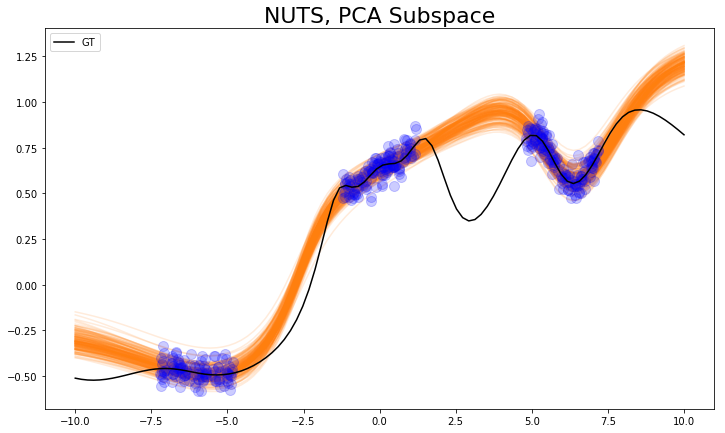

In [96]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))


trajectories = []
for i in range(200):
    pyro_model.t.set_(samples[i, :])
    out = pyro_model(inp)
#     plt.plot(z, out.detach().numpy().ravel(), '-', label="SWAG Sample-"+str(i+1), color=sns.color_palette()[i+2])
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    trajectories.append(out.detach().numpy().ravel())

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('NUTS, PCA Subspace', fontsize=22)
plt.legend()
plt.show()

np.savez("../../uai2k19_text/figs/data/toyreg/rand_nuts_traj.npz", 
            trajectories=trajectories,
             x=z
        )

In [97]:
# np.savez("../../uai2k19_text/figs/data/toyreg/rand_nuts_samples.npz",
#          samples=samples.numpy(),
#          cov_factor=subspace.cov_factor.numpy(),
#          mean=subspace.mean.numpy()
#         )

### NUTS-Curve

In [21]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import HMC, MCMC, NUTS

from swag.posteriors.pyro import PyroModel
from swag.utils import extract_parameters, set_weights

import math

In [22]:
subspace, W, mean, D = get_curve_space()
init_sigma = 1.
prior_sigma = 1.

pyro_model = PyroModel(
    base=model_cfg.base,
    subspace=subspace,
    prior_log_sigma=math.log(prior_sigma), 
    likelihood_given_outputs=lambda x: dist.Normal(x, np.sqrt(0.5)),
    *model_cfg.args,
    **model_cfg.kwargs
)

In [23]:
nuts_kernel = NUTS(pyro_model.model, step_size=1.)

In [24]:
x_, y_ = loader.dataset.tensors
mcmc_run = MCMC(nuts_kernel, num_samples=200, warmup_steps=200).run(x_, y_)
samples = torch.cat(list(mcmc_run.marginal(sites="t").support(flatten=True).values()), dim=-1)
# samples

Sample: 100%|██████████| 400/400 [01:47<00:00,  5.26it/s, step size=6.79e-02, acc. rate=0.915]


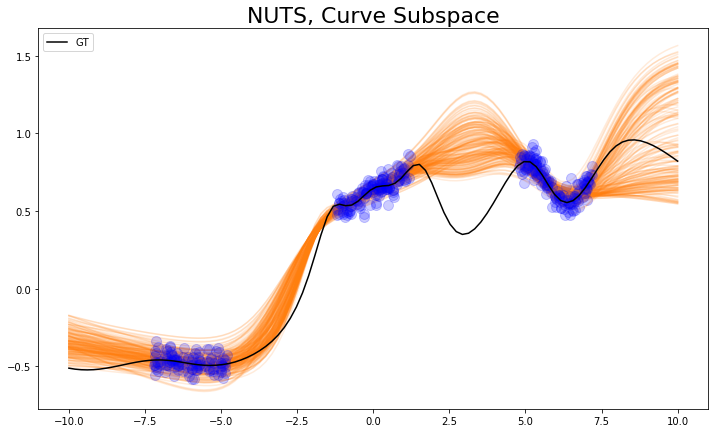

In [25]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))


trajectories = []
for i in range(200):
    pyro_model.t.set_(samples[i, :])
    out = pyro_model(inp)
#     plt.plot(z, out.detach().numpy().ravel(), '-', label="SWAG Sample-"+str(i+1), color=sns.color_palette()[i+2])
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    trajectories.append(out.detach().numpy().ravel())

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('NUTS, Curve Subspace', fontsize=22)
plt.legend()
plt.show()

np.savez("../../uai2k19_text/figs/data/toyreg/curve_nuts_traj.npz", 
            trajectories=trajectories,
            x=z
        )

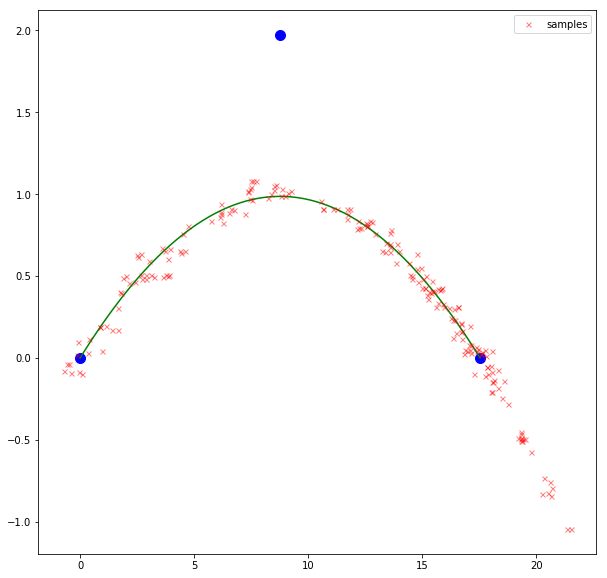

In [26]:
# samples = torch.cat([pyro_model.sample()[None,:] for _ in range(500)]).data.numpy()
visualize_samples(W, D, mean, samples.numpy(), with_curve=True)

In [27]:
np.savez("../../uai2k19_text/figs/data/toyreg/curve_nuts_samples.npz",
         samples=samples.numpy(),
         cov_factor=D,
         mean=mean
        )

torch.save(pyro_model.state_dict(), "toyreg_nuts_curve.pt")

## Elliptical Slice Sampling

### PCA Model

In [86]:
from swag.posteriors.ess import EllipticalSliceSampling
import copy

In [87]:
subspace = get_pca_space()

In [88]:
ess_model = EllipticalSliceSampling(
    base=model_cfg.base,
    subspace=subspace,
    var=None,
    loader=loader, 
    criterion=losses.GaussianLikelihood(noise_var=.5), 
    num_samples=1000,
    use_cuda = False,
    *model_cfg.args,
    **model_cfg.kwargs
)
ess_model.fit(scale=50.**2)

100%|██████████| 1000/1000 [00:23<00:00, 41.94it/s]


array([-1.31043172, -1.43655944, -1.44964254, -1.4144733 , -1.59521043,
       -1.37423706, -1.31085658, -1.23476887, -1.32343829, -1.38140512,
       -1.12676084, -1.23041081, -2.34677458, -3.99144101, -3.85833931,
       -4.73342609, -4.86708641, -1.38504052, -1.30681443, -1.5016681 ,
       -1.64762676, -1.51010799, -1.49637401, -1.54183745, -1.71436262,
       -2.32558894, -2.1287744 , -2.72891569, -2.18016124, -1.37679565,
       -1.16261697, -1.28123617, -1.50854635, -1.19333196, -1.18706465,
       -1.88230741, -1.8435024 , -1.78892875, -1.89064682, -1.83054805,
       -1.4747479 , -2.57748461, -1.9006834 , -1.52375162, -2.83890057,
       -2.41023779, -2.06045914, -2.61056161, -3.72546577, -3.32799077,
       -1.29531026, -1.29791772, -2.56971121, -2.25022507, -2.53888655,
       -3.05429816, -3.09161925, -2.40057778, -2.23072648, -1.95101273,
       -1.93957222, -1.85515976, -1.59954619, -2.39175916, -1.49412346,
       -1.60105765, -2.07857132, -1.74565411, -1.35273123, -1.32

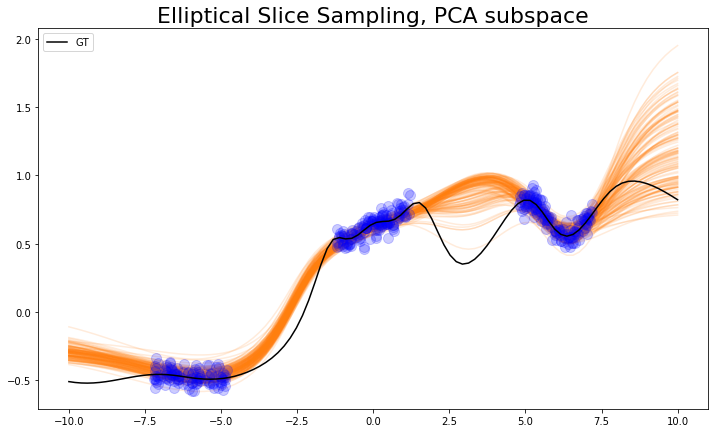

In [89]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))

trajectories = []
for i in range(150):
    ess_model.sample()
    out = ess_model(inp)
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    trajectories.append(out.detach().numpy().ravel())

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('Elliptical Slice Sampling, PCA subspace', fontsize=22)
plt.legend()
plt.show()

# np.savez("../../uai2k19_text/figs/data/toyreg/pca_ess_traj.npz", 
#             trajectories=trajectories,
#             x=z
#         )

In [90]:
# samples = torch.cat([ess_model.sample()[None, :] for _ in range(500)]).data.numpy()
# np.savez("../../uai2k19_text/figs/data/toyreg/pca_ess_samples.npz",
#          samples=samples,
#          cov_factor=subspace.cov_factor.numpy(),
#          mean=subspace.mean.numpy()
#         )

### ESS-Random

In [83]:
from swag.posteriors.ess import EllipticalSliceSampling
import copy

subspace = get_rand_space()

ess_model = EllipticalSliceSampling(
    base=model_cfg.base,
    subspace=subspace,
    var=None,
    loader=loader, 
    criterion=losses.GaussianLikelihood(noise_var=.5), 
    num_samples=2000,
    use_cuda = False,
    *model_cfg.args,
    **model_cfg.kwargs
)
ess_model.fit(scale=50.**2)

100%|██████████| 2000/2000 [00:35<00:00, 55.94it/s]


array([-1.15709257, -1.37739062, -1.19211149, ..., -1.66514969,
       -1.98660851, -2.09161258])

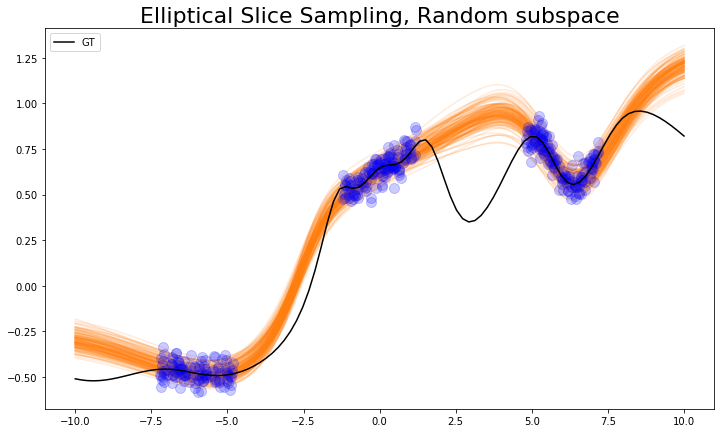

In [84]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))

trajectories = []
for i in range(150):
    ess_model.sample()
    out = ess_model(inp)
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    trajectories.append(out.detach().numpy().ravel())

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('Elliptical Slice Sampling, Random subspace', fontsize=22)
plt.legend()
plt.show()

# np.savez("../../uai2k19_text/figs/data/toyreg/rand_ess_traj.npz", 
#             trajectories=trajectories,
#             x=z
#         )

In [85]:
# samples = torch.cat([ess_model.sample()[None, :] for _ in range(500)]).data.numpy()
# np.savez("../../uai2k19_text/figs/data/toyreg/rand_ess_samples.npz",
#          samples=samples,
#          cov_factor=subspace.cov_factor.numpy(),
#          mean=subspace.mean.numpy()
#         )

### Curve Subspace

In [34]:
from swag.posteriors.ess import EllipticalSliceSampling
import copy

subspace, W, mean, D = get_curve_space()

ess_model = EllipticalSliceSampling(
    base=model_cfg.base,
    subspace=subspace,
    var=None,
    loader=loader, 
    criterion=losses.GaussianLikelihood(noise_var=.5), 
    num_samples=1000,
    use_cuda = False,
    *model_cfg.args,
    **model_cfg.kwargs
)
ess_model.fit(scale=1.)

100%|██████████| 1000/1000 [00:45<00:00, 22.19it/s]


array([-111.93447113,   -4.73251629,   -1.23214459,   -1.15070796,
         -1.20450926,   -1.28269649,   -1.25875187,   -1.5239706 ,
         -1.19666696,   -1.48909461,   -1.39361417,   -2.11301136,
         -1.19121563,   -1.16309142,   -1.52807379,   -1.54652882,
         -1.13583338,   -2.19899797,   -1.1783725 ,   -2.56337595,
         -1.7768625 ,   -2.80064034,   -1.79309058,   -3.18703938,
         -2.40560699,   -1.41165197,   -4.50875854,   -1.76728559,
         -1.42829823,   -1.58293307,   -1.45507157,   -1.41235757,
         -1.63332713,   -1.39459562,   -1.39705086,   -1.72531211,
         -1.38771009,   -1.77526569,   -3.16930866,   -1.70500684,
         -1.56824255,   -1.38491642,   -1.39018571,   -1.63270342,
         -1.94765532,   -1.33278453,   -1.3481859 ,   -1.23729002,
         -1.404284  ,   -2.60820866,   -2.3892312 ,   -2.04037571,
         -1.9114908 ,   -1.85379159,   -1.20322227,   -2.19366503,
         -1.59649718,   -1.61230826,   -1.49080181,   -1.29582

In [35]:
# ess_model.load_state_dict(torch.load("toyreg_ess_curve.pt"))

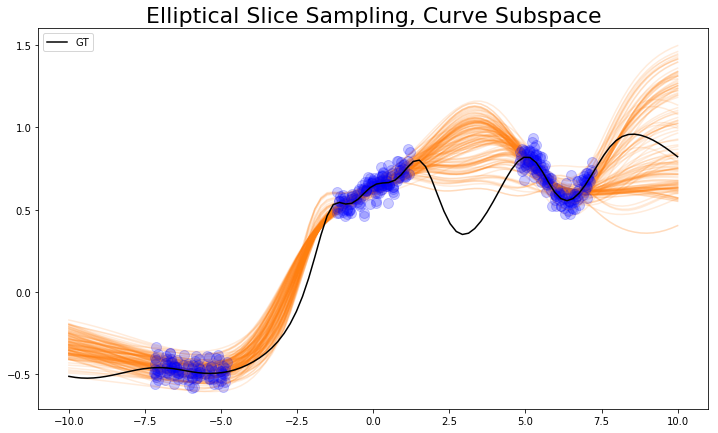

In [36]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))

trajectories = []
for i in range(150):
    ess_model.sample()
    out = ess_model(inp)
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    trajectories.append(out.detach().numpy().ravel())

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('Elliptical Slice Sampling, Curve Subspace', fontsize=22)
plt.legend()
plt.show()

# np.savez("../../uai2k19_text/figs/data/toyreg/curve_ess_traj.npz", 
#             trajectories=trajectories,
#             x=z
#         )

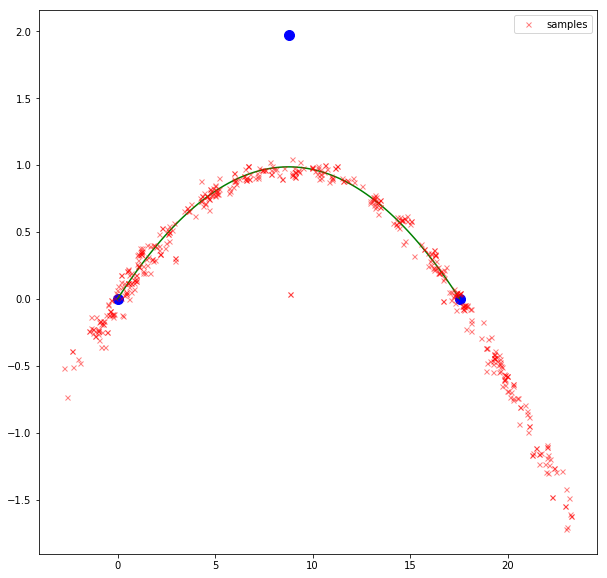

In [37]:
samples = torch.cat([ess_model.sample()[None, :] for _ in range(500)]).data.numpy()
visualize_samples(W, D, mean, samples, with_curve=True)

In [38]:
# np.savez("../../uai2k19_text/figs/data/toyreg/curve_ess_samples.npz",
#          samples=samples,
#          cov_factor=D,
#          mean=mean
#         )

# torch.save(ess_model.state_dict(), "toyreg_ess_curve.pt")

### Multimodal subspace

In [40]:
W = []
for i in model_lst:
    model.load_state_dict(torch.load("reg_model_final_" + str(i+1) + ".pt"))
    W.append(np.concatenate([param.data.numpy().reshape(-1) for param in model.parameters()]))
W = np.vstack(W)

In [41]:
mean = np.mean(W, axis=0)
D = W - mean[None, :]
# D /= np.linalg.norm(D, axis=1)
mean = torch.from_numpy(mean)
D = torch.from_numpy(D)
D = D[:-1]
subspace = SubspaceModel(mean, D)

In [42]:
ess_model = EllipticalSliceSampling(
    base=model_cfg.base,
    subspace=subspace,
    var=None,
    loader=loader, 
    criterion=losses.GaussianLikelihood(noise_var=.1), 
    num_samples=5000,
    use_cuda = False,
    *model_cfg.args,
    **model_cfg.kwargs
)
ess_model.fit()

100%|██████████| 5000/5000 [04:15<00:00, 19.60it/s]


array([-423.88195801, -344.00411987, -317.04495239, ...,   -7.67453146,
         -5.96512079,   -5.15761614])

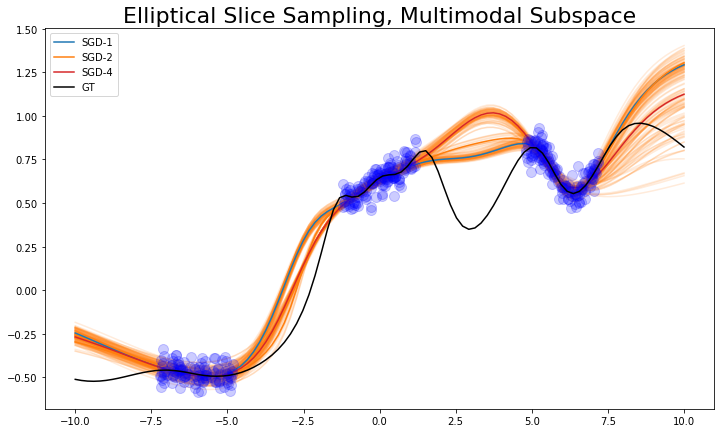

In [43]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))

for i in range(150):
    ess_model.sample()
    out = ess_model(inp)
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    
for i in model_lst:
    model.load_state_dict(torch.load("reg_model_final_" + str(i+1) + ".pt"))
    out = model(inp)
    plt.plot(z, out.detach().numpy().ravel(), '-', label="SGD-"+str(i+1), color=sns.color_palette()[i])

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('Elliptical Slice Sampling, Multimodal Subspace', fontsize=22)
plt.legend()
plt.show()

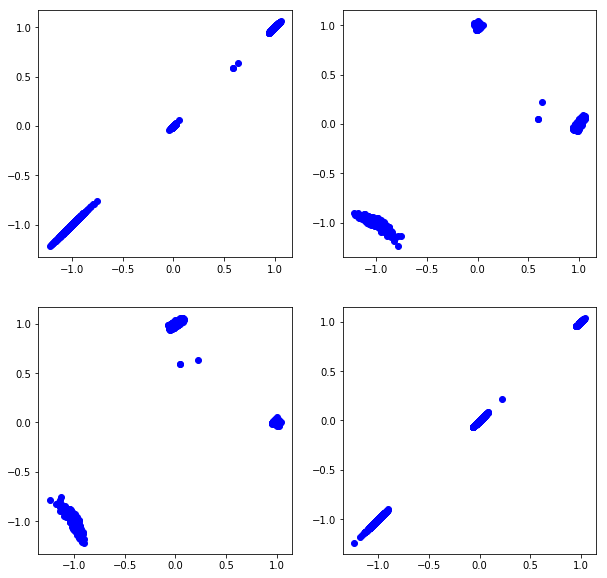

In [44]:
samples = torch.cat([ess_model.sample()[None, :] for _ in range(1000)]).data.numpy()

f, ax = plt.subplots(2,2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        ax[i, j].plot(samples[:, i], samples[:, j], "bo")

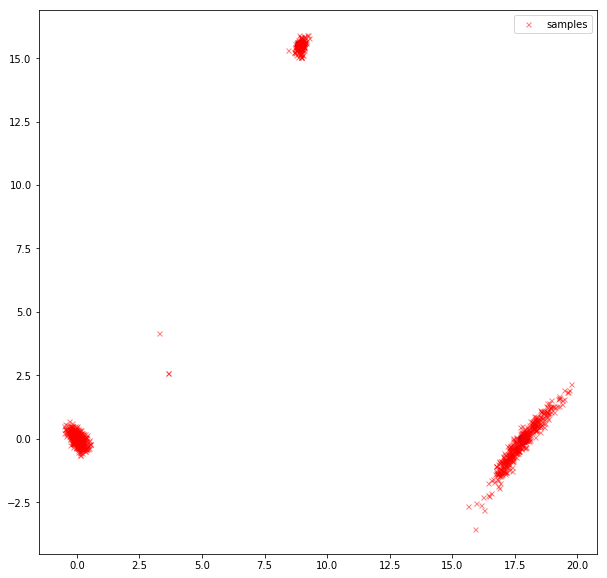

In [46]:
visualize_samples(W, D, mean, samples, with_curve=False)

### Random Subspace

In [98]:
swag_model = SWAG(model_cfg.base, subspace_type="pca", *model_cfg.args, **model_cfg.kwargs, 
                  subspace_kwargs={"max_rank": 10, "pca_rank": 10})
swag_model.load_state_dict(torch.load("swag-reg_final-3000.pt")["state_dict"])

mean, _, cov_factor = swag_model.get_space()
# swag_model.load_state_dict(torch.load("swag-reg-3000.pt")["state_dict"])
cov_factor = torch.randn_like(cov_factor) 
cov_factor /= torch.norm(cov_factor, dim=1)[:, None]
cov_factor *= 1e-2
subspace = SubspaceModel(mean, cov_factor)

In [103]:
ess_model = EllipticalSliceSampling(
    base=model_cfg.base,
    subspace=subspace,
    var=None,
    loader=loader, 
    criterion=losses.GaussianLikelihood(noise_var=.5), 
    num_samples=2000,
    use_cuda = False,
    *model_cfg.args,
    **model_cfg.kwargs
)
ess_model.fit(scale=50)

100%|██████████| 2000/2000 [00:20<00:00, 95.97it/s]


array([-1.13837743, -1.18220675, -1.15629494, ..., -1.1486119 ,
       -1.14506388, -1.14398956])

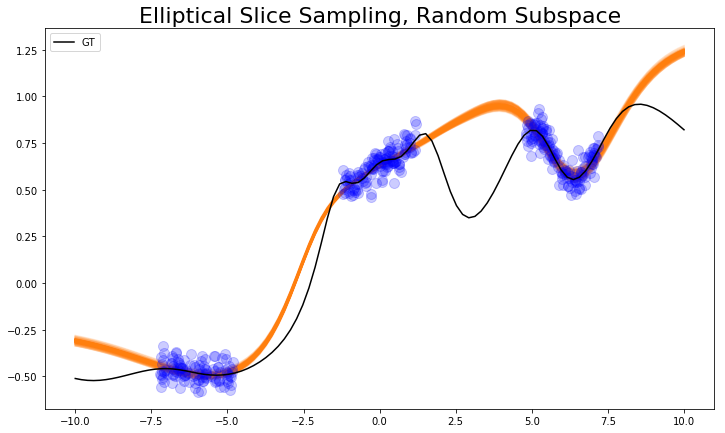

In [104]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))

for i in range(150):
    ess_model.sample()
    out = ess_model(inp)
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('Elliptical Slice Sampling, Random Subspace', fontsize=22)
plt.legend()
plt.show()

# Real NVP PCA subspace

In [72]:
from torch import nn, distributions
import math


In [73]:
class GaussianLikelihood:
    """
    Minus Gaussian likelihood for regression problems.

    Mean squared error (MSE) divided by `2 * noise_var`.
    """
    
    def __init__(self, noise_var=.5):
        self.noise_var = noise_var
        self.mse = torch.nn.functional.mse_loss
    
    def __call__(self, output, target):
        mse = self.mse(output, target)
        loss = mse / (2 * self.noise_var)

        return loss, {"mse": mse}

In [74]:
class Nets(nn.Module):
    def __init__(self, D, inner_dim, inner_layers):
        super().__init__()
        self.seq_part = nn.Sequential(nn.Linear(D, inner_dim),
                                 nn.ReLU(),
                                 *inner_seq(inner_layers, inner_dim),
                                 nn.Linear(inner_dim, D),
                                 nn.Tanh())
        self.scale = nn.Parameter(torch.ones(D))
        
    
    def forward(self, x):
        x = self.seq_part.forward(x)
        x = self.scale * x
        return x
    

def inner_seq(n, inner_dim):
    res = []
    for _ in range(n):
        res.append(nn.Linear(inner_dim, inner_dim))
        res.append(nn.ReLU())
    return res

def get_toy_nvp(D, coupling_layers_num=5, inner_dim=128, inner_layers=5, prior=None, device=None):
#     nets = lambda: nn.Sequential(nn.Linear(D, inner_dim),
#                                  nn.ReLU(),
#                                  *inner_seq(inner_layers, inner_dim),
#                                  nn.Linear(inner_dim, D),
#                                  nn.Tanh())
    nets = lambda: Nets(D, inner_dim, inner_layers)
    # a function that take no arguments and return a pytorch model, dim(X) -> dim(X)
    nett = lambda: nn.Sequential(nn.Linear(D, inner_dim),
                                 nn.ReLU(),
                                 *inner_seq(inner_layers, inner_dim),
                                 nn.Linear(inner_dim, D))
    
    if prior is None:
        prior = distributions.MultivariateNormal(torch.zeros(D).to(device),
                                                 torch.eye(D).to(device))
        
    d = D // 2
    masks = torch.zeros(coupling_layers_num, D)
    for i in range(masks.size(0)):
#         masks[i, np.random.randint(2, size=d)] = 1.0
        if i % 2:
            masks[i, :d] = 1.
        else:
            masks[i, d:] = 1.
    print(masks)
    return RealNVP(nets, nett, masks, prior, device=device)

### RNVP PCA-subspace

In [75]:
from swag.posteriors.vinf_model import VINFModel, ELBO_NF
from swag.posteriors.realnvp import RealNVP

subspace = get_pca_space()

nvp_flow = get_toy_nvp(10, inner_layers=2, inner_dim=100)

prior_sigma = 50.
criterion = GaussianLikelihood(noise_var=.5)

vi_nf_model = VINFModel(
    base=model_cfg.base,
    subspace=subspace,
    flow=nvp_flow,
    prior_log_sigma=math.log(prior_sigma),
    *model_cfg.args,
    **model_cfg.kwargs
)

elbo_nf = ELBO_NF(criterion, len(loader.dataset))
optimizer = torch.optim.Adam([param for param in vi_nf_model.parameters()], lr=1e-2)

tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])


In [76]:
for epoch in range(1000):
    train_res = utils.train_epoch(loader, vi_nf_model, elbo_nf, optimizer, regression=True, cuda=False)
    if epoch % 100 == 0:
        print(epoch, train_res)
        t = vi_nf_model.flow.sample()
    if epoch == 500:
        utils.adjust_learning_rate(optimizer, 0.001)

0 {'loss': -0.061357525642961264, 'accuracy': None, 'stats': {'nll': 0.013270602939883247, 'kl': -29.85125184059143}}
100 {'loss': -0.11177095957100391, 'accuracy': None, 'stats': {'nll': 0.003913250053301454, 'kl': -46.27368402481079}}
200 {'loss': -0.10947345569729805, 'accuracy': None, 'stats': {'nll': 0.004733345005661249, 'kl': -45.68272018432617}}
300 {'loss': -0.11229190975427628, 'accuracy': None, 'stats': {'nll': 0.005363660311559215, 'kl': -47.062228202819824}}
400 {'loss': -0.11057546082884073, 'accuracy': None, 'stats': {'nll': 0.003925564757082611, 'kl': -45.80040979385376}}
500 {'loss': -0.11018708441406488, 'accuracy': None, 'stats': {'nll': 0.004526207689195871, 'kl': -45.88531684875488}}
600 {'loss': -0.11203307937830687, 'accuracy': None, 'stats': {'nll': 0.0034037208824884146, 'kl': -46.17471885681152}}
700 {'loss': -0.11122423876076937, 'accuracy': None, 'stats': {'nll': 0.004244817246217281, 'kl': -46.18762254714966}}
800 {'loss': -0.11088192369788885, 'accuracy': 

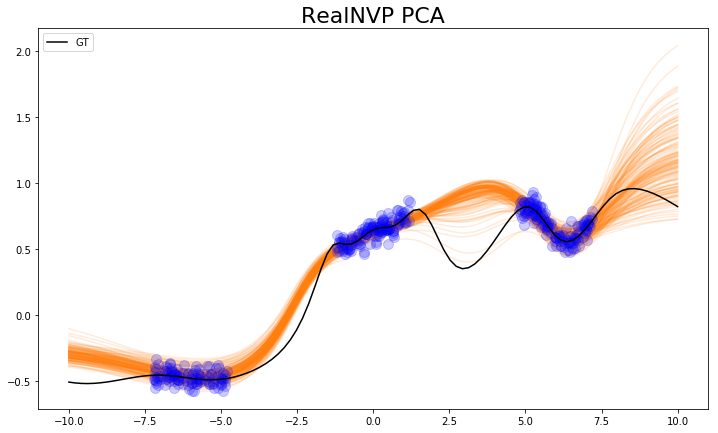

In [77]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))
    
trajectories = []
for i in range(150):
    t = vi_nf_model.flow.sample()
    out = vi_nf_model(inp, t=t)
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    trajectories.append(out.detach().numpy().ravel())
    
plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('RealNVP PCA', fontsize=22)
plt.legend()
plt.show()

np.savez("../../uai2k19_text/figs/data/toyreg/pca_rnvp_traj.npz", 
            trajectories=trajectories,
            x=z
        )

In [78]:
samples = torch.cat([vi_nf_model.flow.sample()[None, 0, :] for _ in range(500)]).data.numpy()

np.savez("../../uai2k19_text/figs/data/toyreg/pca_rnvp_samples.npz",
         samples=samples,
         cov_factor=subspace.cov_factor.numpy(),
         mean=subspace.mean.numpy()
        )

### RNVP Random

In [79]:
from swag.posteriors.vinf_model import VINFModel, ELBO_NF
from swag.posteriors.realnvp import RealNVP

subspace = get_rand_space()

nvp_flow = get_toy_nvp(10, inner_layers=2, inner_dim=100)

prior_sigma = 50.
criterion = GaussianLikelihood(noise_var=.5)

vi_nf_model = VINFModel(
    base=model_cfg.base,
    subspace=subspace,
    flow=nvp_flow,
    prior_log_sigma=math.log(prior_sigma),
    *model_cfg.args,
    **model_cfg.kwargs
)

elbo_nf = ELBO_NF(criterion, len(loader.dataset))
optimizer = torch.optim.Adam([param for param in vi_nf_model.parameters()], lr=1e-2)

tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])


In [80]:
for epoch in range(1000):
    train_res = utils.train_epoch(loader, vi_nf_model, elbo_nf, optimizer, regression=True, cuda=False)
    if epoch % 100 == 0:
        print(epoch, train_res)
        t = vi_nf_model.flow.sample()
    if epoch == 500:
        utils.adjust_learning_rate(optimizer, 0.001)

0 {'loss': -0.06965060019865632, 'accuracy': None, 'stats': {'nll': 0.00440933887148276, 'kl': -29.623976230621338}}
100 {'loss': -0.11189149133861065, 'accuracy': None, 'stats': {'nll': 0.008467746083624661, 'kl': -48.14369487762451}}
200 {'loss': -0.11277681775391102, 'accuracy': None, 'stats': {'nll': 0.004932179988827556, 'kl': -47.08359956741333}}
300 {'loss': -0.1136368066072464, 'accuracy': None, 'stats': {'nll': 0.00534636082011275, 'kl': -47.5932674407959}}
400 {'loss': -0.11358585860580206, 'accuracy': None, 'stats': {'nll': 0.004610463831340894, 'kl': -47.27852916717529}}
500 {'loss': -0.11196301784366369, 'accuracy': None, 'stats': {'nll': 0.007131807098630816, 'kl': -47.637929916381836}}
600 {'loss': -0.11473130341619253, 'accuracy': None, 'stats': {'nll': 0.00464221861329861, 'kl': -47.74940872192383}}
700 {'loss': -0.11360393092036247, 'accuracy': None, 'stats': {'nll': 0.0057962262944784015, 'kl': -47.76006269454956}}
800 {'loss': -0.11379639338701963, 'accuracy': None,

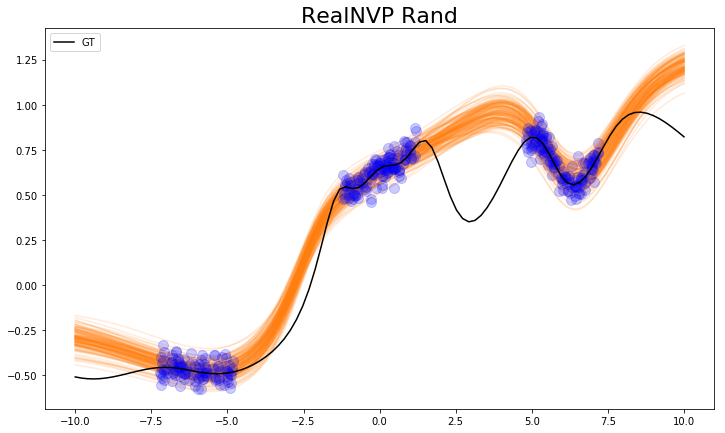

In [81]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))
    
trajectories = []
for i in range(150):
    t = vi_nf_model.flow.sample()
    out = vi_nf_model(inp, t=t)
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    trajectories.append(out.detach().numpy().ravel())
    
plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('RealNVP Rand', fontsize=22)
plt.legend()
plt.show()

# np.savez("../../uai2k19_text/figs/data/toyreg/rand_rnvp_traj.npz", 
#             trajectories=trajectories,
#             x=z
#         )

In [82]:
# samples = torch.cat([vi_nf_model.flow.sample()[None, 0, :] for _ in range(500)]).data.numpy()

# np.savez("../../uai2k19_text/figs/data/toyreg/rand_rnvp_samples.npz",
#          samples=samples,
#          cov_factor=subspace.cov_factor.numpy(),
#          mean=subspace.mean.numpy()
#         )

### Curve space

In [42]:
from swag.posteriors.vinf_model import VINFModel, ELBO_NF
from swag.posteriors.realnvp import RealNVP

subspace, W, mean, D = get_curve_space()

nvp_flow = get_toy_nvp(2, inner_layers=2, inner_dim=100)

prior_sigma = 50.
criterion = GaussianLikelihood(noise_var=.5)

vi_nf_model = VINFModel(
    base=model_cfg.base,
    subspace=subspace,
    flow=nvp_flow,
    prior_log_sigma=math.log(prior_sigma),
    *model_cfg.args,
    **model_cfg.kwargs
)

elbo_nf = ELBO_NF(criterion, len(loader.dataset))
optimizer = torch.optim.Adam([param for param in vi_nf_model.parameters()], lr=1e-2)

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])


In [43]:
for epoch in range(1000):
    train_res = utils.train_epoch(loader, vi_nf_model, elbo_nf, optimizer, regression=True, cuda=False)
    if epoch % 100 == 0:
        print(epoch, train_res)
        t = vi_nf_model.flow.sample()
    if epoch == 500:
        utils.adjust_learning_rate(optimizer, 0.001)

0 {'loss': 0.5447851195931435, 'accuracy': None, 'stats': {'nll': 0.5440517798124347, 'kl': 0.293332003057003}}
100 {'loss': 0.012120902887545526, 'accuracy': None, 'stats': {'nll': 0.004780230374308303, 'kl': 2.9362690299749374}}
200 {'loss': 0.012620646972209215, 'accuracy': None, 'stats': {'nll': 0.004908046510536224, 'kl': 3.0850401148200035}}
300 {'loss': 0.010639385785907507, 'accuracy': None, 'stats': {'nll': 0.004118614713661373, 'kl': 2.6083084046840668}}
400 {'loss': 0.011796837556175888, 'accuracy': None, 'stats': {'nll': 0.004926857509417459, 'kl': 2.7479920089244843}}
500 {'loss': 0.012335321633145213, 'accuracy': None, 'stats': {'nll': 0.005752021446824074, 'kl': 2.6333200335502625}}
600 {'loss': 0.009225553891155869, 'accuracy': None, 'stats': {'nll': 0.0037452293618116528, 'kl': 2.1921297907829285}}
700 {'loss': 0.009612943307729438, 'accuracy': None, 'stats': {'nll': 0.004863263835432008, 'kl': 1.899871781701222}}
800 {'loss': 0.009656021604314446, 'accuracy': None, 's

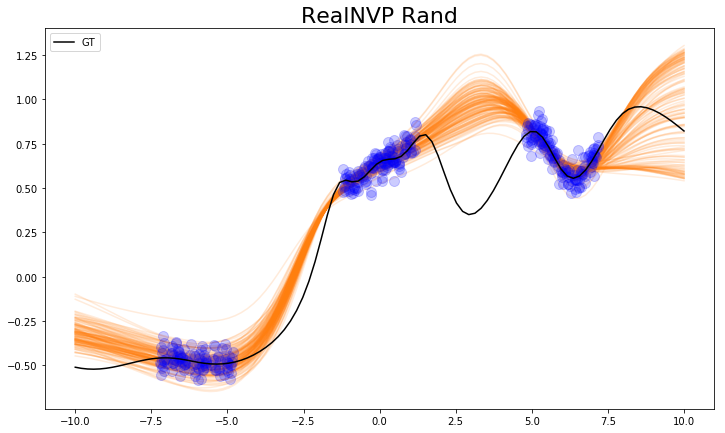

In [44]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))
    
trajectories = []
for i in range(150):
    t = vi_nf_model.flow.sample()
    out = vi_nf_model(inp, t=t)
    plt.plot(z, out.detach().numpy().ravel(), '-', color=sns.color_palette()[1], alpha=0.15)
    trajectories.append(out.detach().numpy().ravel())
    
plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('RealNVP Rand', fontsize=22)
plt.legend()
plt.show()

np.savez("../../uai2k19_text/figs/data/toyreg/curve_rnvp_traj.npz", 
            trajectories=trajectories,
            x=z
        )

In [46]:
samples.shape

(500, 1, 2)

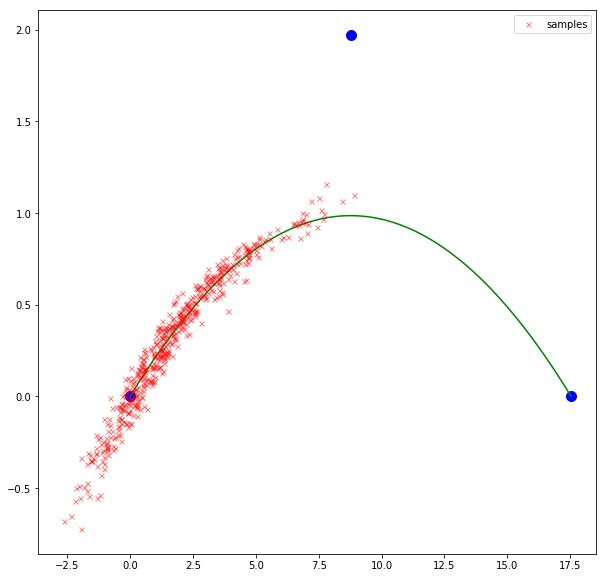

In [47]:
samples = torch.cat([vi_nf_model.flow.sample()[None, 0, :] for _ in range(500)]).data.numpy()
visualize_samples(W, D, mean, samples, with_curve=True)

In [48]:
# np.savez("../../uai2k19_text/figs/data/toyreg/curve_rnvp_samples.npz",
#          samples=samples,
#          cov_factor=D,
#          mean=mean
#         )

# torch.save(vi_nf_model.state_dict(), "toyreg_rnvp_curve.pt")

## FFG VI

In [30]:
from swag.posteriors.ffg_vi_model import VIFFGModel
from swag.posteriors.vi_model import ELBO
import math

ImportError: cannot import name 'extract_parameters'

In [150]:
init_sigma = .1
prior_sigma = .06
criterion = losses.GaussianLikelihood(noise_var=.1)

vi_model = VIFFGModel(
    init_inv_softplus_sigma=math.log(math.exp(init_sigma) - 1.0),
    prior_log_sigma=math.log(prior_sigma),
    base=model_cfg.base,
    *model_cfg.args,
    **model_cfg.kwargs
)

elbo = ELBO(criterion, len(loader.dataset) * 20)
optimizer = torch.optim.Adam([param for param in vi_model.parameters()], lr=.01)

In [151]:
for epoch in range(2000):
    train_res = utils.train_epoch(loader, vi_model, elbo, optimizer, regression=True, cuda=False)
    sigma = torch.nn.functional.softplus(vi_model.inv_softplus_sigma.detach().cpu())
    if epoch % 100 == 0:
        print(epoch, train_res)
    if epoch == 1000:
        utils.adjust_learning_rate(optimizer, 0.001)

0 {'accuracy': None, 'stats': {'nll': 1.9087883830070496, 'entropy': -36458.60107421875, 'kl': 1.8452823609113693}, 'loss': 3.7540707290172577}
100 {'accuracy': None, 'stats': {'nll': 0.23198015429079533, 'entropy': -40468.19287109375, 'kl': 1.5804240554571152}, 'loss': 1.8124042004346848}
200 {'accuracy': None, 'stats': {'nll': 0.07874046382494271, 'entropy': -42887.1767578125, 'kl': 1.295834630727768}, 'loss': 1.3745751082897186}
300 {'accuracy': None, 'stats': {'nll': 0.04689189582131803, 'entropy': -44047.255859375, 'kl': 1.2479906976222992}, 'loss': 1.2948825806379318}
400 {'accuracy': None, 'stats': {'nll': 0.0797753157094121, 'entropy': -44570.99755859375, 'kl': 1.4163642525672913}, 'loss': 1.4961395561695099}
500 {'accuracy': None, 'stats': {'nll': 0.06939195841550827, 'entropy': -44709.88427734375, 'kl': 1.1607947498559952}, 'loss': 1.2301867008209229}
600 {'accuracy': None, 'stats': {'nll': 0.045508551178500056, 'entropy': -44790.84375, 'kl': 1.1389711797237396}, 'loss': 1.18

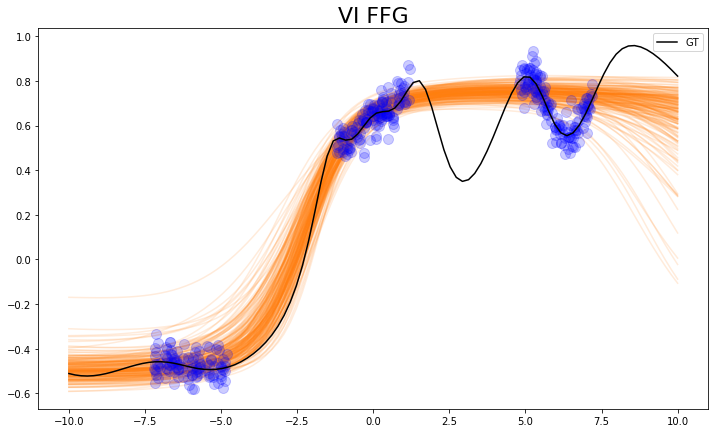

In [154]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
plt.figure(figsize=(12, 7))

trajectories = []
for i in range(200):
    out = vi_model(inp)
    trajectories.append(out.detach().numpy().ravel()[None, :])
    
trajectories = np.vstack(trajectories)
for traj in trajectories:
    plt.plot(z, traj, '-', color=sns.color_palette()[1], alpha=0.15)

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)
model.load_state_dict(torch.load("data_generator3.pt"))
out = model(inp)
plt.plot(z, out.detach().numpy().ravel(), 'k-', alpha=1., label="GT")
plt.title('VI FFG', fontsize=22)
plt.legend()
plt.show()
np.savez("../../uai2k19_text/figs/data/toyreg/vi_traj.npz", 
            trajectories=trajectories,
             x=z
        )

## Gaussian Process

In [155]:
import gpytorch

In [156]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_, y_[:, 0], likelihood)

In [157]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_)
    # Calc loss and backprop gradients
    loss = -mll(output, y_[:, 0])
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.log_lengthscale.item(),
        model.likelihood.log_noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.989   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/50 - Loss: 0.924   log_lengthscale: 0.100   log_noise: -0.100
Iter 3/50 - Loss: 0.879   log_lengthscale: 0.189   log_noise: -0.200
Iter 4/50 - Loss: 0.827   log_lengthscale: 0.282   log_noise: -0.300
Iter 5/50 - Loss: 0.778   log_lengthscale: 0.376   log_noise: -0.400
Iter 6/50 - Loss: 0.727   log_lengthscale: 0.471   log_noise: -0.500
Iter 7/50 - Loss: 0.667   log_lengthscale: 0.567   log_noise: -0.600
Iter 8/50 - Loss: 0.616   log_lengthscale: 0.662   log_noise: -0.700
Iter 9/50 - Loss: 0.572   log_lengthscale: 0.755   log_noise: -0.800
Iter 10/50 - Loss: 0.521   log_lengthscale: 0.848   log_noise: -0.901
Iter 11/50 - Loss: 0.471   log_lengthscale: 0.941   log_noise: -1.001
Iter 12/50 - Loss: 0.417   log_lengthscale: 1.034   log_noise: -1.101
Iter 13/50 - Loss: 0.367   log_lengthscale: 1.127   log_noise: -1.201
Iter 14/50 - Loss: 0.316   log_lengthscale: 1.215   log_noise: -1.301
Iter 15/50 - Loss: 0.266   log

In [158]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

AttributeError: module 'gpytorch.settings' has no attribute 'fast_pred_var'

No handles with labels found to put in legend.


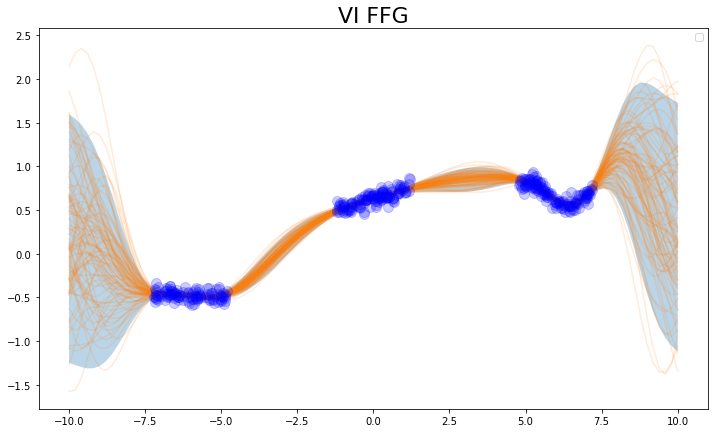

In [159]:

model.eval()
likelihood.eval()

z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
with torch.no_grad():
    out = model(inp)
lower, upper = out.confidence_region()

plt.figure(figsize=(12, 7))

trajectories = []
for i in range(100):
    trajectories.append(out.sample().detach().numpy()[None, :])
    
trajectories = np.vstack(trajectories)
for traj in trajectories:
    plt.plot(z, traj, '-', color=sns.color_palette()[1], alpha=0.15)

plt.plot(x, y, 'bo', markersize=10, alpha=0.2)

plt.fill_between(z, lower.detach().numpy(), upper.detach().numpy(), alpha=0.3)

plt.title('VI FFG', fontsize=22)
plt.legend()
plt.show()
np.savez("../../uai2k19_text/figs/data/toyreg/gp_traj.npz", 
         trajectories=trajectories,
         x=z,
         mean=out.mean.detach().numpy(),
         sigma=np.sqrt(out.variance.detach().numpy())
        )